In [10]:
# MSFR 경로 지정

import sys

sys.path.append('../..')

In [11]:
# MSFR 레이어 단일 모델

from torch import Tensor
from torch import device
import torch.nn as nn
from msfr import MSFR

cpu = device('cpu')

class MSFRModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.msfr = MSFR(1, 1, device=cpu)

    def forward(self, x: Tensor) -> Tensor:
        return self.msfr(x)


In [12]:
# 샘플 데이터 생성

import random
from torch import Tensor
from torch import randint
from torch import sin

x_values = [random.uniform(0, 30) for _ in range(100)]
x_tensor = Tensor(x_values, device=cpu).view(-1, 1)  # (50, 1) 형태로 변환
y_tensor = 10*sin(x_tensor) + (randint(-1, 2, x_tensor.shape).float() * 0.5)  # 약간의 노이즈 추가


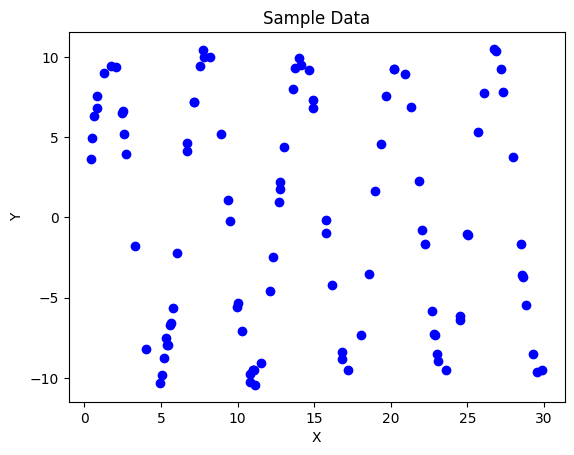

In [13]:
# 샘플 데이터 시각화

import matplotlib.pyplot as plt

plt.scatter(x_tensor.numpy(), y_tensor.numpy(), color='blue', label='Data Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sample Data')
plt.show()

In [18]:
# 모델 학습 및 출력 확인

from torch.optim import Adam
from torch.nn import MSELoss

def stats(t):
    return float(t.mean().item()), float(t.std().item())

model = MSFRModel()
optimizer = Adam(model.parameters(), lr=5e-2)
loss_fn = MSELoss()

epochs = 100
for epoch in range(1, epochs + 1):
    output = model(x_tensor)
    loss = loss_fn(output, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    print(">>> CYCLES:", model.msfr.cycle.data.cpu().numpy())
    if model.msfr.cycle.grad is not None:
        print("cycle grad mean/std:", stats(model.msfr.cycle.grad))
    if model.msfr.weight.grad is not None:
        print("weight grad mean/std:", stats(model.msfr.weight.grad))
    if model.msfr.bias.grad is not None:
        print("bias grad mean/std:", stats(model.msfr.bias.grad))
    # optional: param norms
    print("weight norm:", model.msfr.weight.data.norm().item(), "bias norm:", model.msfr.bias.data.norm().item())
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

>>> CYCLES: [6.001673]
cycle grad mean/std: (9.688396453857422, nan)
weight grad mean/std: (-2.201739549636841, 3.1742565631866455)
bias grad mean/std: (0.4106784462928772, nan)
weight norm: 0.5163326859474182 bias norm: 0.143193781375885
Epoch 1, Loss: 53.802127838134766
>>> CYCLES: [5.951673]
cycle grad mean/std: (20.752174377441406, nan)
weight grad mean/std: (-2.463064670562744, 3.438507318496704)
bias grad mean/std: (0.3149259388446808, nan)
weight norm: 0.47551867365837097 bias norm: 0.09319378435611725
Epoch 2, Loss: 52.16954040527344
>>> CYCLES: [5.9037895]
cycle grad mean/std: (23.463430404663086, nan)
weight grad mean/std: (-2.426852226257324, 3.7327980995178223)
bias grad mean/std: (0.1887596845626831, nan)
weight norm: 0.4627537131309509 bias norm: 0.04396462067961693
Epoch 3, Loss: 50.21051788330078
>>> CYCLES: [5.855079]
cycle grad mean/std: (15.785957336425781, nan)
weight grad mean/std: (-2.0624001026153564, 4.031144142150879)
bias grad mean/std: (0.04071216285228729, n

C:\Users\rrayy\AppData\Local\Temp\ipykernel_22828\764621516.py:7: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  return float(t.mean().item()), float(t.std().item())


In [19]:
# 모델 학습 결과 출력

from torch import no_grad

with no_grad():
    predicted = model(x_tensor)
    print("Predicted values:", predicted.squeeze().numpy())

Predicted values: [-5.85472    -5.5762672   4.770466    5.612881   -6.3330564   6.3532515
 -5.5976114  -5.0951347   5.0443296  -6.123048    0.84277976  5.6328306
  6.4687924  -6.135102    5.857871   -6.273472    0.3159033   2.3975363
  5.451518    5.0449877  -5.073477   -6.2100596  -4.5550814   3.066523
  4.206367   -0.21196276  1.1782745   1.8629605   4.8211284   6.2187843
 -6.0684676   2.3842602   4.101148    3.7055101  -2.2692847   5.166696
 -1.1400095   6.5268784  -6.3182306  -5.514153    5.9855647  -2.9867115
  4.5364795  -6.432173    5.8436213  -1.1373338  -4.071633    3.958582
 -6.5391464  -6.3441496   0.31829035  4.6058474  -6.3837495  -1.3542118
 -5.146236    5.291131    5.0433216   2.906506   -1.1632144   2.3244433
  4.768052   -1.7621695  -6.0906086  -1.6013132   3.7456713  -6.227918
  6.533675    2.7928529   1.7640035   4.7625275   6.5372834   0.8428043
 -1.7806851  -3.6471977   2.5744958  -5.472689    0.4124905  -3.5300198
  4.5951395  -1.763292   -5.476966   -6.188849    

In [20]:
# 모델 파라미터 출력

bias = model.msfr.bias.detach().numpy()
cycle = model.msfr.cycle.detach().numpy()
weight = model.msfr.weight.detach().numpy()

print(f"Bias: {bias}")
print(f"Cycle: {cycle}")
print(f"Weight: {weight}")

Bias: [0.55727375]
Cycle: [5.806216]
Weight: [[-0.07422648 -0.80095494  4.36107     1.4617672   1.6785337  -3.1611066 ]]


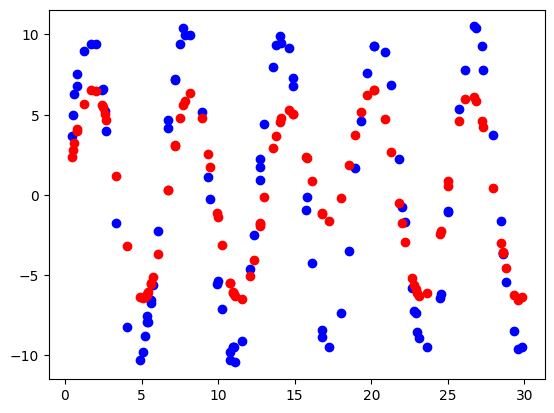

In [21]:
# 모델 학습 결과 시각화 및 비교

plt.scatter(x_tensor.numpy(), y_tensor.numpy(), color='blue', label='Data Points')
plt.scatter(x_tensor.numpy(), predicted.numpy(), color='red', label='MSFR Prediction')